In [1]:
%matplotlib inline
%load_ext mcmc
%mcmc notebook
import matplotlib.pyplot as plt
#import numpy as np
import autograd
from autograd import numpy as np
from autograd.scipy import stats
import numpy as true_np
import sympy as sp
sp.init_printing()
import bayesian_pdes as bpdes
import matplotlib
import mcmc
#matplotlib.rc('text', usetex=True)
#matplotlib.rcParams['text.latex.unicode'] = True

In [2]:
class NamedLambda(object):
    def __init__(self, func, desc):
        self.__func__ = func
        self.__desc__ = desc
    def __call__(self, *args):
        return self.__func__(*args)
    def __str__(self):
        return '<NamedLambda: {}>'.format(self.__desc__)
    def __repr__(self):
        return '<NamedLambda: {}>'.format(self.__desc__)

In [3]:
true = np.loadtxt('true_linear_elliptic.txt')
true_x = np.array(true[:,:2])
seed = 124
np.random.seed(seed)
r = np.random.normal(0, 0.01, len(true))
true_u = (true[:,2] + r).reshape((len(true), 1))

In [4]:
S = 5

In [5]:
x_1, x_2, y_1, y_2 = sp.symbols('x_1, x_2, y_1, y_2')
length_scale = sp.Symbol('sigma')
k_sqexp = sp.exp(-((x_1-y_1)**2 + (x_2-y_2)**2) / (2*length_scale**2))

# Operators in the expanded version of the problem
A_1 = NamedLambda(lambda k: k.diff(x_1), 'A_1')
A_2 = NamedLambda(lambda k: k.diff(x_2), 'A_2')
A_3 = NamedLambda(lambda k: k.diff(x_1, x_1) + k.diff(x_2, x_2), 'A_3')
A_1_bar = NamedLambda(lambda k: k.diff(y_1), 'A_1_bar')
A_2_bar = NamedLambda(lambda k: k.diff(y_2), 'A_2_bar')
A_3_bar = NamedLambda(lambda k: k.diff(y_1, y_1) + k.diff(y_2, y_2), 'A_3_bar')

# Transformed operators
A_t = 'A_t'
A_bar_t = 'A_bar_t'

Identity = lambda k: k
# Boundary operators
B_1 = NamedLambda(Identity, 'B_1')
B_1_bar = NamedLambda(Identity, 'B_1_bar')
B_2 = NamedLambda(lambda k: k.diff(x_1), 'B_2')
B_2_bar = NamedLambda(lambda k: k.diff(y_1), 'B_2_bar')

# Transformed boundary operators

ops = [A_t, B_1, B_2]
ops_bar = [A_bar_t, B_1_bar, B_2_bar]

ops_base = [A_1, A_2, A_3, B_1, B_2]
ops_bar_base = [A_1_bar, A_2_bar, A_3_bar, B_1_bar, B_2_bar]
op_cache_base = bpdes.operator_compilation.compile_sympy(ops_base, ops_bar_base, k_sqexp, [[x_1, x_2], [y_1, y_2], length_scale], mode='f2py')

In [6]:
arg_caching = bpdes.operator_compilation.CachingOpCache(op_cache_base)

In [7]:
def cfun(x, theta):
    log_c = 0. \
        + theta[0] * np.cos(2*np.pi*x[:,0]) \
        + theta[1] * np.cos(2*np.pi*x[:,1]) \
        + theta[2] * np.cos(2*np.pi*(x[:,0] + x[:,1])) \
        + theta[3] * np.cos(4*np.pi*x[:,0]) \
        + theta[4] * np.cos(4*np.pi*x[:,1])
    return np.exp(log_c)
def log_c_x_fun(x, theta):
    return - theta[0] * 2*np.pi * np.sin(2*np.pi*x[:,0]) \
        - theta[2] * 2*np.pi * np.sin(2*np.pi*(x[:,0] + x[:,1])) \
        - theta[3] * 4*np.pi * np.sin(4*np.pi*(x[:,0]))
        
def log_c_y_fun(x, theta):
    return - theta[1] * 2*np.pi * np.sin(2*np.pi*x[:,1]) \
        - theta[2] * 2*np.pi * np.sin(2*np.pi*(x[:,0] + x[:,1])) \
        - theta[4] * 4*np.pi * np.sin(4*np.pi*(x[:,1]))

In [8]:
from __future__ import print_function

class TransformedOpCache(object):
    def __init__(self, op_cache, kappa, verbosity=0):
        self.__op_cache__ = op_cache
        self.__kappa__ = kappa
        self.__verbosity__ = verbosity
    
    def __getitem__(self, item):
        return do_transform(item, self.__op_cache__, self.__kappa__, self.__verbosity__)
    
def do_transform(item, op_cache, kappa, verbosity):
    def printer(*args):
        if verbosity > 0:
            print(*args)
    c = cfun(interior, kappa)[:,None]
    grad_log_c_x = log_c_x_fun(interior, kappa)[:,None]
    grad_log_c_y = log_c_y_fun(interior, kappa)[:,None]
    all_things = [()]
    
    # first explode out the objects required
    for i in item:
        if i == A_t:
            all_things = sum([[a + (A_1,), a + (A_2,), a + (A_3,)] for a in all_things], [])
        elif i == A_bar_t:
            all_things = sum([[a + (A_1_bar,), a + (A_2_bar,), a + (A_3_bar,)] for a in all_things], [])
        else:
            all_things = [a + (i,) for a in all_things]
    printer(all_things)

    def __calc_result(x,y,*fun_args):
        result = 0
        for item in all_things:
            try:
                function = op_cache[item]
            except Exception as ex:
                printer('Failed to get {}'.format(item))
                raise ex
            new_mat = function(x,y,*fun_args)
            if A_1 in item:
                printer('A_1')
                new_mat = np.repeat(grad_log_c_x * c, y.shape[0],1) * new_mat
            if A_2 in item:
                printer('A_2')
                new_mat = np.repeat(grad_log_c_y * c, y.shape[0],1) * new_mat
            elif A_3 in item:
                printer('A_3')
                new_mat = np.repeat(c, y.shape[0],1) * new_mat
            if A_1_bar in item:
                printer('A_1_bar')
                new_mat = np.repeat(grad_log_c_x.T*c.T, x.shape[0],0) * new_mat
            if A_2_bar in item:
                printer('A_2_bar')
                new_mat = np.repeat(grad_log_c_y.T*c.T, x.shape[0],0) * new_mat
            elif A_3_bar in item:
                printer('A_3_bar')
                new_mat = np.repeat(c.T, x.shape[0],0) * new_mat
            # autograd doesn't like +=
            result = result + new_mat
        return result
    return __calc_result

In [9]:
# autograd is missing mgrid
all_x, all_y = true_np.mgrid[0:1:11j, 0:1:11j]
all = np.c_[all_x.ravel(), all_y.ravel()]
neumann_flags = ((all[:,0] == 0) | (all[:,0] == 1)) & (all[:,1] != 0) & (all[:,1] != 1)
dirichlet_flags = ((all[:,1] == 0) | (all[:,1] == 1))
interior_flags = ~neumann_flags & ~dirichlet_flags
dirichlet = all[dirichlet_flags, :]
neumann = all[neumann_flags, :]
interior = all[interior_flags, :]

In [10]:
interior_obs = np.zeros((interior.shape[0], 1))

dirichlet_obs = dirichlet[:,0].copy()
dirichlet_obs[dirichlet[:,1] == 1] = 1-dirichlet_obs[dirichlet[:,1] == 1]
dirichlet_obs = dirichlet_obs[:,None]

neumann_obs = np.zeros((neumann.shape[0], 1))

obs = [
    (interior, interior_obs),
    (dirichlet, dirichlet_obs),
    (neumann, neumann_obs)
]

In [11]:
ls = np.array([0.2])

In [12]:
true_theta = np.ones(5)
oc = TransformedOpCache(arg_caching, true_theta)
posterior = bpdes.collocate(ops, ops_bar, None, None, obs, oc, fun_args=[ls])

In [13]:
test_x, test_y = true_np.mgrid[0:1:40j,0:1:40j]
mu, Sigma = posterior(np.c_[test_x.ravel(), test_y.ravel()])
mu_shaped = mu.reshape(test_x.shape)

/Users/benorn/.virtualenvs/stats/lib/python2.7/site-packages/autograd/numpy/numpy_wrapper.py:54: UserWarning: r_ is slow for array inputs. np.concatenate() is faster.
  "np.concatenate() is faster.".format(slow_op_name))


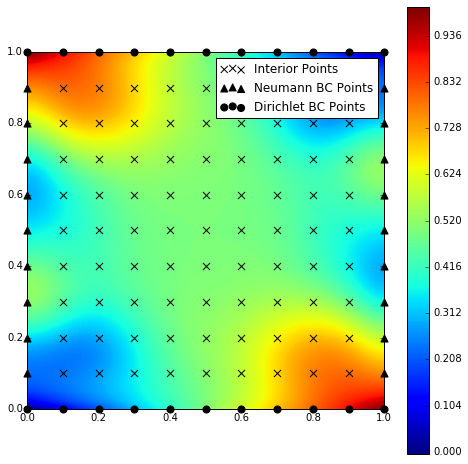

In [14]:
plt.figure(figsize=(8,8))
import matplotlib.tri as tri
#plt.tripcolor(test_x.ravel(), test_y.ravel(), mu.ravel())
colors = plt.contourf(test_x, test_y, mu_shaped,  250)
plt.colorbar(colors)
plt.scatter(interior[:,0], interior[:,1],  marker='x', c='black', s=50, label='Interior Points')
plt.scatter(neumann[:,0], neumann[:,1], marker='^', c='black', clip_on=False, s=50, label='Neumann BC Points')
plt.scatter(dirichlet[:,0], dirichlet[:,1], marker='o', c='black', clip_on=False, s=50, label='Dirichlet BC Points')
plt.legend()
plt.axis('scaled')
plt.xlim(0,1); plt.ylim(0,1);
plt.gcf().patch.set_alpha(0.0)

In [15]:
def propose(current):
    return np.random.normal(current, proposal_sigma)
def log_likelihood(theta):
    oc = TransformedOpCache(arg_caching, theta)
    posterior = bpdes.collocate(ops, ops_bar, None, None, obs, oc, fun_args=[ls])
    mu,cov = posterior(true_x)
    mu = mu.reshape((len(mu), 1))
    cov_with_error = cov + likelihood_sigma**2*np.eye(cov.shape[0])
    #return stats.multivariate_normal.logpdf(mu.ravel(), true_u.ravel(), cov_with_error)
    return -((mu - true_u)**2).sum() / (2 * likelihood_sigma**2)
def log_prior_lognormal(theta):
    if np.any(theta <= 0): return np.log(0)
    p = stats.norm.logpdf(np.log(theta), np.ones_like(theta), 1.) - np.log(theta)
    return np.sum(p)
def log_prior_normal(theta):
    p = stats.norm.logpdf(theta, np.zeros_like(theta), 1.)
    return np.sum(p)
def log_prior_uniform(theta):
    theta_min = -10.
    theta_max = 10.
    if any((theta < theta_min) | (theta > theta_max)):
        return np.log(0)
    return 1.0

In [16]:
gradient = autograd.grad(log_likelihood)

In [17]:
init_theta = np.ones(5)

In [23]:
#init_theta = np.ones(5)
likelihood_sigma = 0.01
proposal_sigma = 0.02
mcmc_thetas = mcmc.rwm(100000, propose, log_likelihood, log_prior_uniform, init_theta)

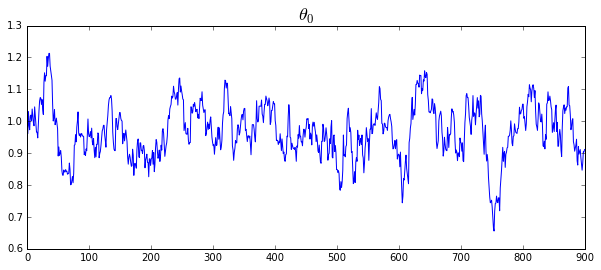

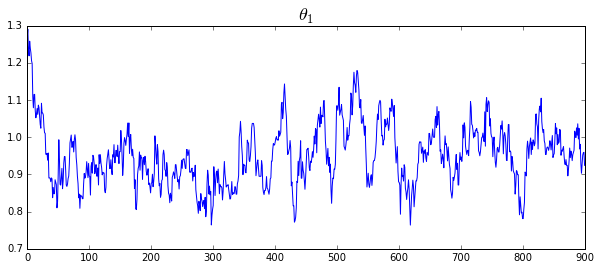

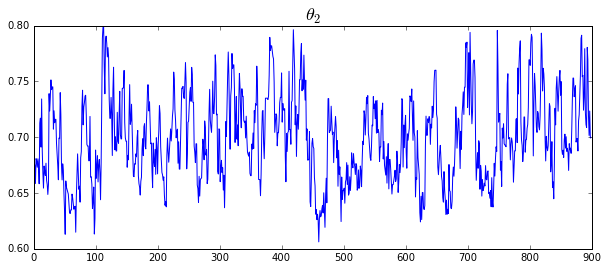

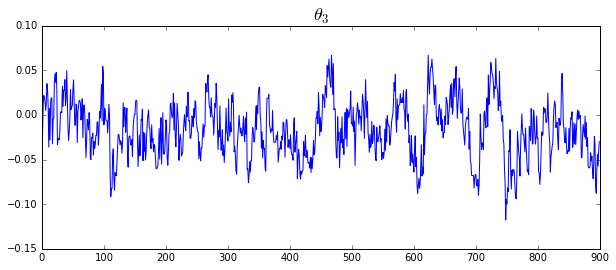

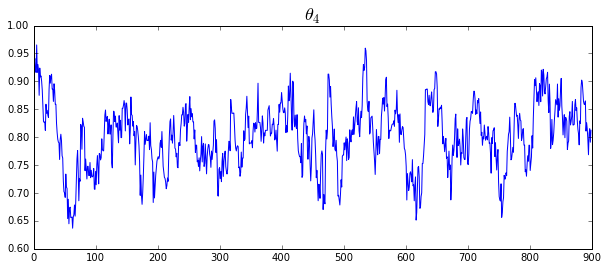

In [24]:
plt.figure(figsize=(8,5))
#print acceptances.sum() * 1./iterations
thin= 10
burn = 1000
thinned_burned = mcmc_thetas[burn:-1:thin, :]
for i in xrange(mcmc_thetas.shape[1]):
    plt.figure(figsize=(10,4))
    plt.plot(thinned_burned[:,i])
    plt.title('$\\theta_{}$'.format(i), fontsize=18)

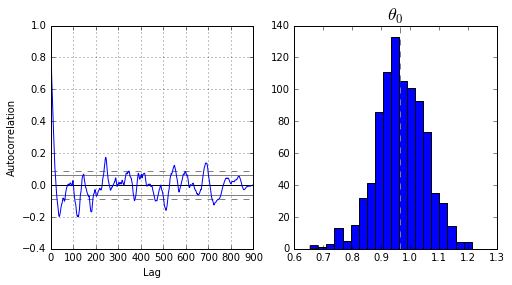

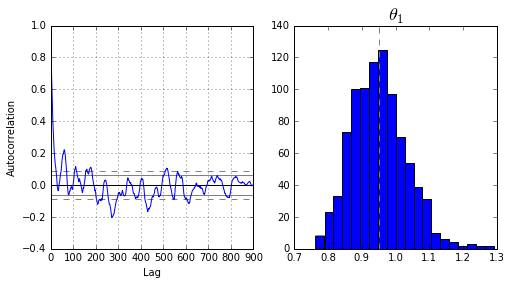

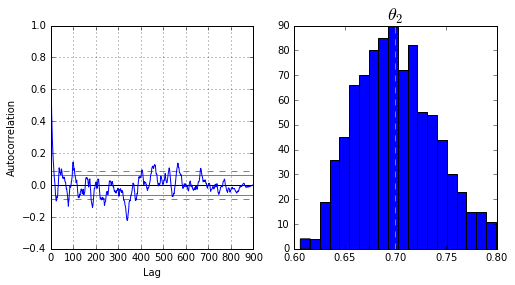

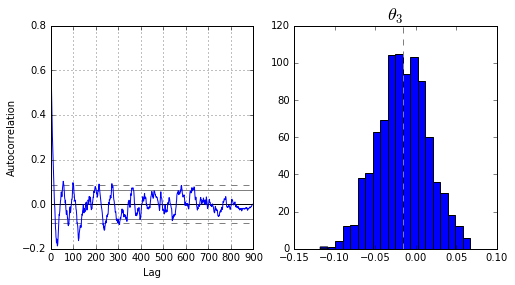

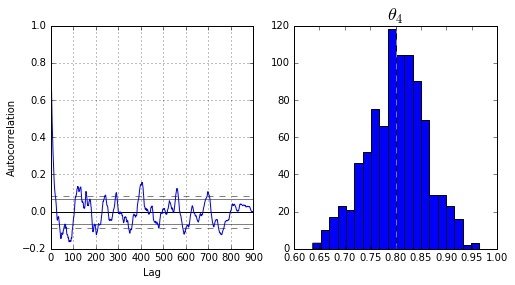

In [25]:
from pandas.tools.plotting import autocorrelation_plot
for i in xrange(thinned_burned.shape[1]):
    t = thinned_burned[:,i]
    plt.figure(figsize=(8,4))
    plt.subplot(121)
    autocorrelation_plot(t, ax=plt.gca())
    plt.subplot(122)
    plt.hist(t, bins=20)
    plt.axvline(t.mean(), linestyle='--', c='gray')
    plt.title('$\\theta_{}$'.format(i), fontsize=18)

In [65]:
grads = np.empty_like(thinned_burned)
for ix in range(thinned_burned.shape[0]):
    if ix % 100 == 0: print('.', end='')
    grads[ix, :] = gradient(thinned_burned[ix, :])

.

KeyboardInterrupt: 

In [97]:
print(np.mean(grads, axis=0))

[ 0.42782554 -0.00313081 -0.14862659 -0.91404187  0.54756044]


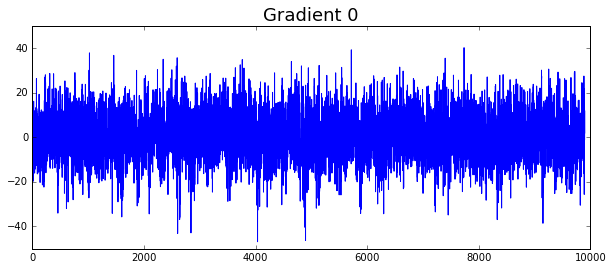

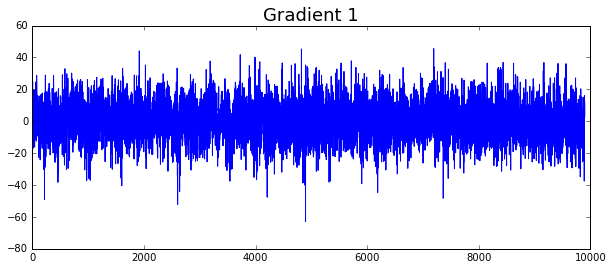

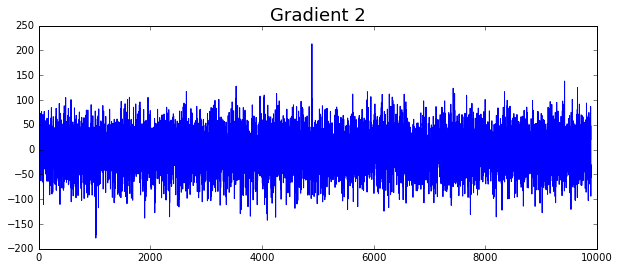

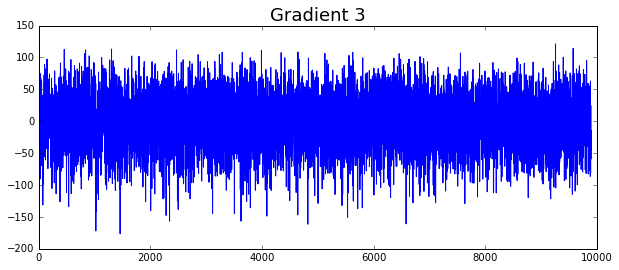

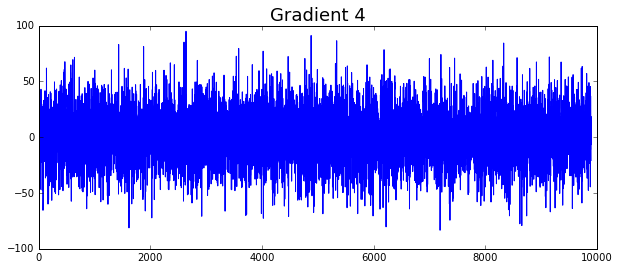

In [113]:
for ix in range(grads.shape[1]):
    plt.figure(figsize=(10,4))
    plt.plot(grads[:,ix])
    plt.title('Gradient {}'.format(ix), fontsize=18)
    plt.show(); plt.close()

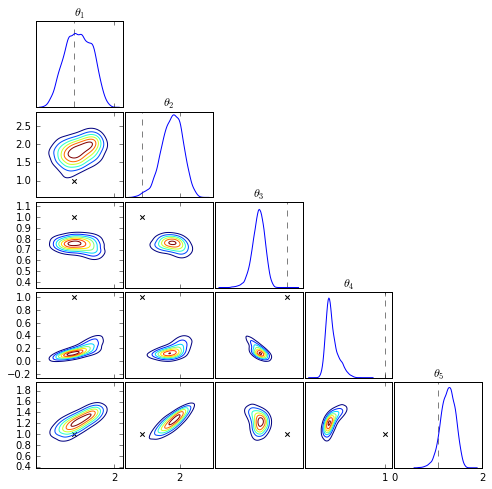

In [104]:
from matplotlib import gridspec
import math
from scipy import stats
plt.figure(figsize=(8,8))
diag = []
n = thinned_burned.shape[1]
gs = gridspec.GridSpec(n, n)
gs.update(wspace=0.025, hspace=0.05)

#levels = [5,20,40,60]
def integers_between(min, max):
    min_int = int(math.floor(min))
    max_int = int(math.ceil(max))
    return range(min_int, max_int+1)

levels = None
for i in range(n):
    i_data = thinned_burned[:,i]
    ax = plt.subplot(gs[n*i + i])
    kde = stats.gaussian_kde(i_data)
    eval_points = np.linspace(i_data.min()-0.1, i_data.max()+0.2, 100)
    #plt.axvline(i_data.mean(), linestyle='--', color='gray')
    plt.axvline(1, linestyle='--', color='gray')
    #plt.axvline(-1, linestyle='--', color='gray')
    plt.plot(eval_points, kde(eval_points))
    plt.title('$\\theta_{}$'.format(i+1))
    
    
    ax.get_yaxis().set_ticks([])
    if i < n-1:
        plt.setp(ax.get_xticklabels(), visible=False)
    else:
        plt.xticks(integers_between(i_data.min(), i_data.max())[::2])
    for j in range(0,i):
        j_data = thinned_burned[:,j]
        subax = plt.subplot(gs[n*i+j], sharex=diag[j])
        #H,xedges,yedges = np.histogram2d(j_data, i_data, bins=20)
        kde = stats.gaussian_kde(np.c_[j_data, i_data].T, bw_method=0.35)
        x,y = true_np.mgrid[j_data.min()-0.1:j_data.max()+0.1:100j, i_data.min()-0.1:i_data.max()+0.2:100j]
        plt.contour(x, y, kde(np.c_[x.ravel(), y.ravel()].T).reshape(x.shape))
        #plt.contour(xedges[:-1], yedges[:-1], H, levels=levels)
        if j > 0:
            subax.get_yaxis().set_ticks([])
        if i < n-1:
            plt.setp(subax.get_xticklabels(), visible=False)
        else:
            plt.xticks(integers_between(j_data.min(), j_data.max())[::2])
        #plt.scatter([1,1,-1,-1],[1,-1,1,-1], marker='x', color='black', linewidth=2, zorder=10)
        plt.scatter(1,1,marker='x', color='black')
    diag.append(ax)
    
plt.gcf().patch.set_alpha(0)
#plt.savefig('PN.pdf', bbox_inches='tight')
#plt.savefig('PN_{}.pdf'.format(seed), bbox_inches='tight')
#np.save('thetas_{}.npy'.format(seed), thetas)

In [103]:
np.savetxt('samples.csv', thinned_burned)
np.savetxt('gradients.csv', grads)

# Plot final sample

In [115]:
log_likelihood(mcmc_thetas[-1, :])

In [117]:
log_likelihood(np.ones(5))

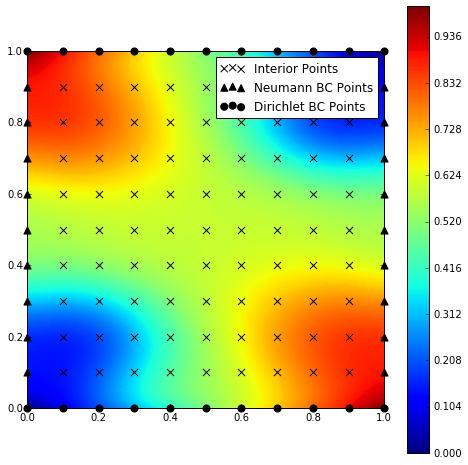

In [114]:
theta = mcmc_thetas[-1,:]
oc = TransformedOpCache(arg_caching, theta)
posterior = bpdes.collocate(ops, ops_bar, None, None, obs, oc)

test_x, test_y = true_np.mgrid[0:1:40j,0:1:40j]
mu, Sigma = posterior(np.c_[test_x.ravel(), test_y.ravel()])
mu_shaped = mu.reshape(test_x.shape)
plt.figure(figsize=(8,8))

#plt.tripcolor(test_x.ravel(), test_y.ravel(), mu.ravel())
colors = plt.contourf(test_x, test_y, mu_shaped,  250)
plt.colorbar(colors)
plt.scatter(interior[:,0], interior[:,1],  marker='x', c='black', s=50, label='Interior Points')
plt.scatter(neumann[:,0], neumann[:,1], marker='^', c='black', clip_on=False, s=50, label='Neumann BC Points')
plt.scatter(dirichlet[:,0], dirichlet[:,1], marker='o', c='black', clip_on=False, s=50, label='Dirichlet BC Points')
plt.legend()
plt.axis('scaled')
plt.xlim(0,1); plt.ylim(0,1);
plt.gcf().patch.set_alpha(0.0)